In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-mri-images-for-brain-tumor-detection


In [2]:
pip install torch torchvision opencv-python matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [3]:
import pandas as pd
import os
# Generate data paths with labels
data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
df

,filepaths,labels
0,/kaggle/input/brain-mri-images-for-brain-tumor...,no
1,/kaggle/input/brain-mri-images-for-brain-tumor...,no
2,/kaggle/input/brain-mri-images-for-brain-tumor...,no
3,/kaggle/input/brain-mri-images-for-brain-tumor...,no
4,/kaggle/input/brain-mri-images-for-brain-tumor...,no
...,...,...
250,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
251,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
252,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
253,/kaggle/input/brain-mri-images-for-brain-tumor...,brain_tumor_dataset


In [5]:
import os
import shutil
import random
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Define paths
data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'
filepaths = []
labels = []

# List directories (yes, no)
folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

# Split data into training and testing sets using train_test_split
strat = df['labels']  # Stratify by labels to maintain class distribution
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

# Define directories for train and test datasets
base_dir = "/kaggle/working/split_dataset"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Ensure the main directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create subfolders for yes and no inside train and test directories
os.makedirs(os.path.join(train_dir, "yes"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "no"), exist_ok=True)

os.makedirs(os.path.join(test_dir, "yes"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "no"), exist_ok=True)

# Function to apply thermal effect to the image
def apply_thermal_effect(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Failed to load image {image_path}")  # Debug message for invalid paths
        return None  # Return None if image couldn't be loaded
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    # Step 1: Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced_gray = clahe.apply(gray)

    # Step 2: Apply Thermal (Heatmap) Effect
    thermal_img = cv2.applyColorMap(enhanced_gray, cv2.COLORMAP_JET)  # Thermal-like effect

    return thermal_img

# Function to copy images from the source folder to the destination folder
def copy_images(image_files, src_folder, dest_folder):
    for image_file in image_files:
        src_path = os.path.join(src_folder, image_file)
        dest_path = os.path.join(dest_folder, image_file)
        shutil.copy(src_path, dest_path)  # Use copy instead of move
        print(f"Copied: {image_file} from {src_folder} to {dest_folder}")  # Debug message

# Now apply thermal effects and copy images for train and test datasets
# Process images for the training set (80%) from train_df to the appropriate train folder (yes or no)
for _, row in train_df.iterrows():
    label = row['labels']
    image_file = os.path.basename(row['filepaths'])
    
    # Copy the original image to the appropriate folder
    if label == 'yes':
        copy_images([image_file], os.path.dirname(row['filepaths']), os.path.join(train_dir, "yes"))
    elif label == 'no':
        copy_images([image_file], os.path.dirname(row['filepaths']), os.path.join(train_dir, "no"))
    
    # Apply thermal effect and save the thermal image in the same folder
    thermal_image = apply_thermal_effect(row['filepaths'])
    if thermal_image is not None:  # Proceed only if the thermal image was successfully created
        thermal_save_path = os.path.join(train_dir, label, f"thermal_{image_file}")
        cv2.imwrite(thermal_save_path, thermal_image)

# Process images for the test set (20%) from test_df to the appropriate test folder (yes or no)
for _, row in test_df.iterrows():
    label = row['labels']
    image_file = os.path.basename(row['filepaths'])
    
    # Copy the original image to the appropriate folder
    if label == 'yes':
        copy_images([image_file], os.path.dirname(row['filepaths']), os.path.join(test_dir, "yes"))
    elif label == 'no':
        copy_images([image_file], os.path.dirname(row['filepaths']), os.path.join(test_dir, "no"))
    
    # Apply thermal effect and save the thermal image in the same folder
    thermal_image = apply_thermal_effect(row['filepaths'])
    if thermal_image is not None:  # Proceed only if the thermal image was successfully created
        thermal_save_path = os.path.join(test_dir, label, f"thermal_{image_file}")
        cv2.imwrite(thermal_save_path, thermal_image)

print(f"Images and thermal effects successfully copied and processed in {train_dir} and {test_dir}.")


Copied: 6 no.jpg from /kaggle/input/brain-mri-images-for-brain-tumor-detection/no to /kaggle/working/split_dataset/train/no
Copied: Y75.JPG from /kaggle/input/brain-mri-images-for-brain-tumor-detection/yes to /kaggle/working/split_dataset/train/yes
Copied: No17.jpg from /kaggle/input/brain-mri-images-for-brain-tumor-detection/no to /kaggle/working/split_dataset/train/no
Copied: N17.jpg from /kaggle/input/brain-mri-images-for-brain-tumor-detection/no to /kaggle/working/split_dataset/train/no
Copied: No11.jpg from /kaggle/input/brain-mri-images-for-brain-tumor-detection/no to /kaggle/working/split_dataset/train/no
Copied: Y47.JPG from /kaggle/input/brain-mri-images-for-brain-tumor-detection/yes to /kaggle/working/split_dataset/train/yes
Copied: Y69.jpg from /kaggle/input/brain-mri-images-for-brain-tumor-detection/yes to /kaggle/working/split_dataset/train/yes
Copied: Y158.JPG from /kaggle/input/brain-mri-images-for-brain-tumor-detection/yes to /kaggle/working/split_dataset/train/yes
Copi

In [6]:
import os

# Define paths for train and test datasets
base_dir = "/kaggle/working/split_dataset"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Count the number of images in each folder (yes/no) in the train and test datasets
train_yes_count = len(os.listdir(os.path.join(train_dir, "yes")))
train_no_count = len(os.listdir(os.path.join(train_dir, "no")))

test_yes_count = len(os.listdir(os.path.join(test_dir, "yes")))
test_no_count = len(os.listdir(os.path.join(test_dir, "no")))

# Display the counts
train_yes_count, train_no_count, test_yes_count, test_no_count


(248, 156, 62, 40)

In [7]:
import os
import shutil
import cv2
import numpy as np

# Define paths for train and test datasets
base_dir = "/kaggle/working/split_dataset"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
train_thermal_dir = os.path.join(base_dir, "train_thermal")
test_thermal_dir = os.path.join(base_dir, "test_thermal")

# Ensure the main directories exist
os.makedirs(train_thermal_dir, exist_ok=True)
os.makedirs(test_thermal_dir, exist_ok=True)

# Create subfolders for yes and no inside train_thermal and test_thermal directories
os.makedirs(os.path.join(train_thermal_dir, "yes"), exist_ok=True)
os.makedirs(os.path.join(train_thermal_dir, "no"), exist_ok=True)

os.makedirs(os.path.join(test_thermal_dir, "yes"), exist_ok=True)
os.makedirs(os.path.join(test_thermal_dir, "no"), exist_ok=True)

# Function to apply thermal effect to the image
def apply_thermal_effect(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    # Step 1: Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced_gray = clahe.apply(gray)

    # Step 2: Apply Thermal (Heatmap) Effect
    thermal_img = cv2.applyColorMap(enhanced_gray, cv2.COLORMAP_JET)  # Thermal-like effect

    return thermal_img

# Function to process the images and save them in the new folder structure
def process_and_save_images(df, destination_dir):
    for _, row in df.iterrows():
        label = row['labels']
        image_file = os.path.basename(row['filepaths'])
        image_name, ext = os.path.splitext(image_file)

        # Ensure we are working with files, not directories
        if os.path.isdir(row['filepaths']):
            print(f"Skipping directory: {row['filepaths']}")
            continue

        # Create a new folder for this image inside train/test directories (named after the image)
        image_folder = os.path.join(destination_dir, label, image_name)
        os.makedirs(image_folder, exist_ok=True)

        # Copy the original image to this new folder
        original_image_path = row['filepaths']
        shutil.copy(original_image_path, os.path.join(image_folder, image_file))

        # Apply thermal effect to the image
        thermal_image = apply_thermal_effect(os.path.join(image_folder, image_file))
        if thermal_image is not None:
            # Save the thermal image with the prefix 'thermal_' in the same folder
            thermal_save_path = os.path.join(image_folder, f"thermal_{image_file}")
            cv2.imwrite(thermal_save_path, thermal_image)
            print(f"Processed and saved: {image_file} and its thermal version.")

# Process and save images for the training set
process_and_save_images(train_df, train_thermal_dir)

# Process and save images for the test set
process_and_save_images(test_df, test_thermal_dir)

print("Images and thermal effects successfully processed and saved in the respective directories.")


Processed and saved: 6 no.jpg and its thermal version.
Processed and saved: Y75.JPG and its thermal version.
Processed and saved: No17.jpg and its thermal version.
Processed and saved: N17.jpg and its thermal version.
Processed and saved: No11.jpg and its thermal version.
Processed and saved: Y47.JPG and its thermal version.
Processed and saved: Y69.jpg and its thermal version.
Processed and saved: Y158.JPG and its thermal version.
Processed and saved: no 92.jpg and its thermal version.
Processed and saved: N15.jpg and its thermal version.
Processed and saved: 41 no.jpg and its thermal version.
Processed and saved: Y153.jpg and its thermal version.
Processed and saved: no 90.jpg and its thermal version.
Processed and saved: No20.jpg and its thermal version.
Processed and saved: 50 no.jpg and its thermal version.
Processed and saved: Y242.JPG and its thermal version.
Processed and saved: No12.jpg and its thermal version.
Processed and saved: Y92.png and its thermal version.
Processed an

Displaying random image from 'yes' class (with tumor):


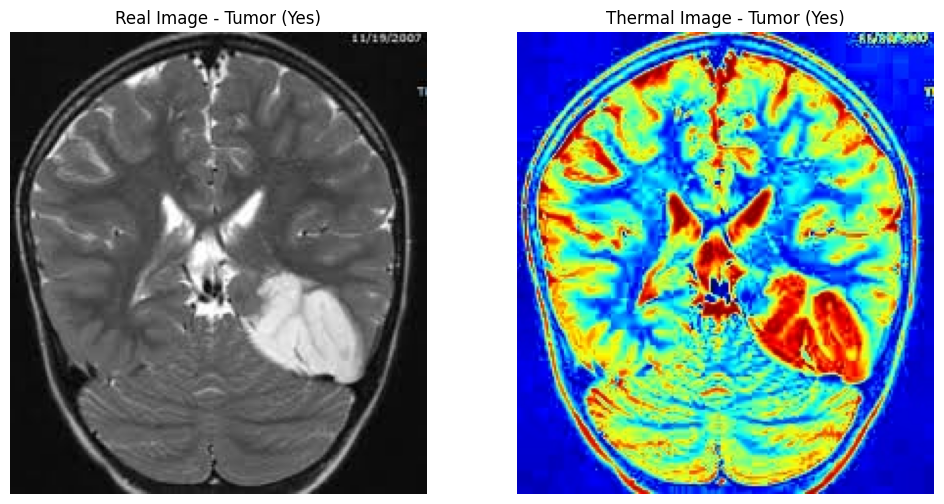

Displaying random image from 'no' class (without tumor):


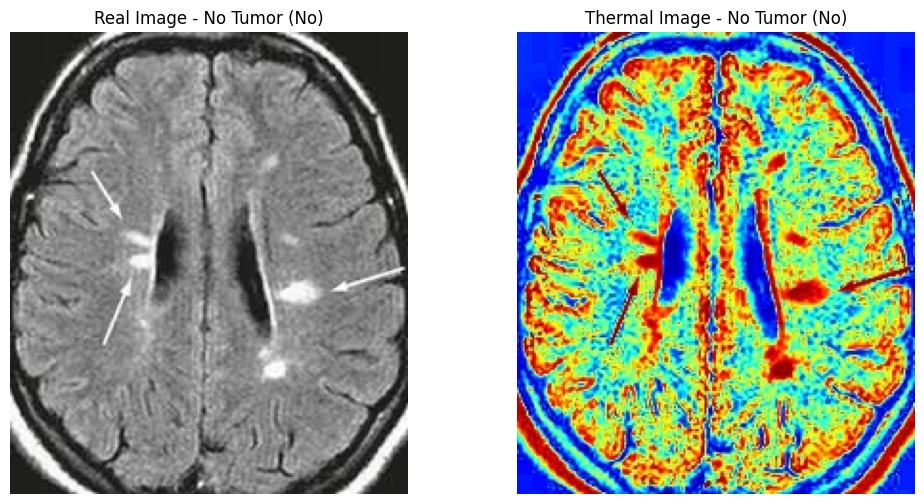

In [30]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Path to the 'yes' and 'no' folders
train_thermal_dir_yes = "/kaggle/working/split_dataset/train_thermal/yes"  # 'yes' folder (with tumor)
train_thermal_dir_no = "/kaggle/working/split_dataset/train_thermal/no"    # 'no' folder (without tumor)

# Function to display a random image from a random subfolder
def display_random_image_from_subfolder(folder_path, label):
    # Get all subfolders (e.g., Y1, Y2, etc.)
    subfolders = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]
    
    # Check if there are any subfolders
    if not subfolders:
        print(f"No subfolders found in {folder_path}. Skipping this folder.")
        return
    
    # Select a random subfolder
    selected_folder = random.choice(subfolders)
    
    # Construct the file paths for real and thermal images inside the selected subfolder
    real_image_path = os.path.join(folder_path, selected_folder, f"{selected_folder}.jpg")
    thermal_image_path = os.path.join(folder_path, selected_folder, f"thermal_{selected_folder}.jpg")
    
    # Check if both real and thermal images exist
    if os.path.exists(real_image_path) and os.path.exists(thermal_image_path):
        # Open and display the images
        real_image = Image.open(real_image_path)
        thermal_image = Image.open(thermal_image_path)
        
        # Plot the real and thermal images side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(real_image)
        axes[0].set_title(f"Real Image - {label}")
        axes[0].axis('off')
        
        axes[1].imshow(thermal_image)
        axes[1].set_title(f"Thermal Image - {label}")
        axes[1].axis('off')
        
        plt.show()
    else:
        print(f"Missing image(s) for folder {selected_folder} in class {label}. Skipping this folder.")

# Display random image from 'yes' (with tumor) class
print("Displaying random image from 'yes' class (with tumor):")
display_random_image_from_subfolder(train_thermal_dir_yes, "Tumor (Yes)")

# Display random image from 'no' (without tumor) class
print("Displaying random image from 'no' class (without tumor):")
display_random_image_from_subfolder(train_thermal_dir_no, "No Tumor (No)")


In [9]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.cuda.amp import autocast, GradScaler

class ThermalImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = ['yes', 'no']  # Assuming only 'yes' and 'no' classes
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        # Load image paths and labels for both real and thermal images
        for label in self.classes:
            class_dir = os.path.join(root_dir, label)
            print(f"Processing class: {label}")
            if os.path.isdir(class_dir):
                for img_folder in os.listdir(class_dir):
                    if img_folder.startswith('.'):
                        continue

                    image_folder_path = os.path.join(class_dir, img_folder)

                    # Skip if it's not a directory
                    if not os.path.isdir(image_folder_path):
                        continue

                    real_image_name = f"{img_folder}.jpg"
                    thermal_image_name = f"thermal_{img_folder}.jpg"

                    real_image_path = os.path.join(image_folder_path, real_image_name)
                    thermal_image_path = os.path.join(image_folder_path, thermal_image_name)

                    # Check if both images exist
                    if os.path.exists(real_image_path) and os.path.exists(thermal_image_path):
                        self.image_paths.append(real_image_path)
                        self.image_paths.append(thermal_image_path)
                        self.labels.append(self.class_to_idx[label])
                        self.labels.append(self.class_to_idx[label])
  #                  else:
#                        print(f"Missing image(s) for folder {img_folder} in class {label}")
 #           else:
#                print(f"Class directory {class_dir} does not exist or is not a directory.")

        print(f"Total images found: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Load image
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset and DataLoader
train_dataset = ThermalImageDataset("/kaggle/working/split_dataset/train_thermal", transform=transform)

# Check the number of items in the dataset
print(f"Number of images in the dataset: {len(train_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)



Processing class: yes
Processing class: no
Total images found: 274
Number of images in the dataset: 274


In [10]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import timm
import torch.nn as nn

# Define device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model (example: using SwinB model from timm)
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

# Modify the final fully connected layer to match the number of classes
num_classes = 2  # Assuming two classes: 'yes' and 'no'
model.head = nn.Linear(model.head.in_features, num_classes)

# Move model to the appropriate device (GPU if available, otherwise CPU)
model = model.to(device)


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

/tmp/ipykernel_36/3475287832.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_36/3475287832.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/100], Loss: 3.2364, Accuracy: 23.36%
Epoch [2/100], Loss: 1.2528, Accuracy: 50.73%
Epoch [3/100], Loss: 0.8247, Accuracy: 59.12%
Epoch [4/100], Loss: 0.7103, Accuracy: 66.06%
Epoch [5/100], Loss: 0.5811, Accuracy: 76.28%
Epoch [6/100], Loss: 0.4300, Accuracy: 82.85%
Epoch [7/100], Loss: 0.3182, Accuracy: 86.50%
Epoch [8/100], Loss: 0.1888, Accuracy: 92.70%
Epoch [9/100], Loss: 0.1531, Accuracy: 96.35%
Epoch [10/100], Loss: 0.1989, Accuracy: 92.34%
Epoch [11/100], Loss: 0.0602, Accuracy: 98.18%
Epoch [12/100], Loss: 0.0429, Accuracy: 98.91%
Epoch [13/100], Loss: 0.1253, Accuracy: 96.35%
Epoch [14/100], Loss: 0.0985, Accuracy: 95.99%
Epoch [15/100], Loss: 0.0257, Accuracy: 99.27%
Epoch [16/100], Loss: 0.0213, Accuracy: 99.27%
Epoch [17/100], Loss: 0.0301, Accuracy: 98.91%
Epoch [18/100], Loss: 0.0122, Accuracy: 99.64%
Epoch [19/100], Loss: 0.0255, Accuracy: 98.91%
Epoch [20/100], Loss: 0.1563, Accuracy: 95.62%
Epoch [21/100], Loss: 0.0566, Accuracy: 97.45%
Epoch [22/100], Loss: 

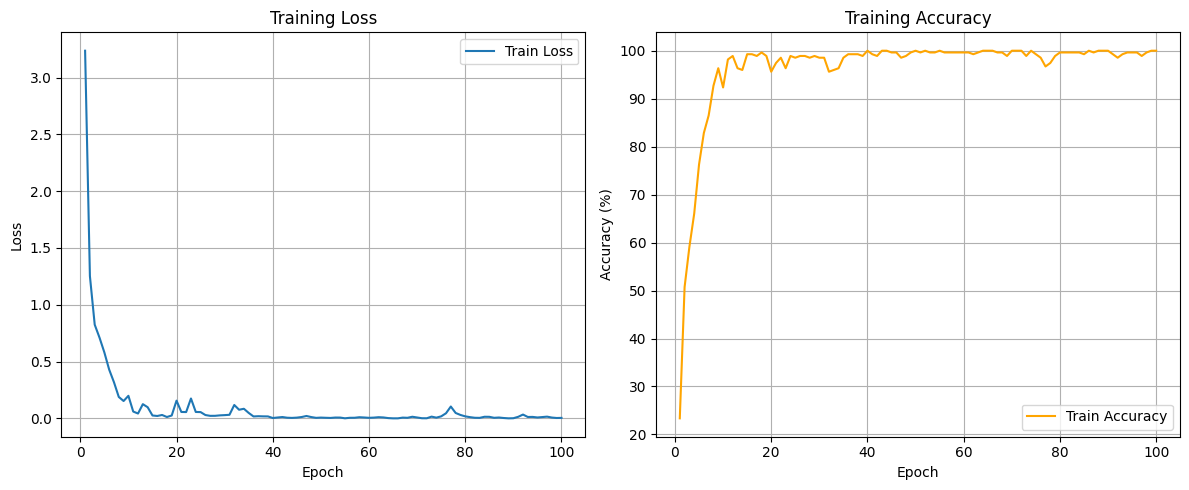

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Mixed Precision Training (if CUDA is available)
scaler = GradScaler()

# Tracking metrics
num_epochs = 100
train_losses = []
train_accuracies = []

# Training loop with mixed precision
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass using autocast for mixed precision
        with autocast():
            outputs = model(images)
            outputs = outputs.flatten(1)  # Flatten the spatial dimensions for classification

            loss = criterion(outputs, labels)

        # Backpropagation with scaling
        optimizer.zero_grad()  # Clear gradients
        scaler.scale(loss).backward()  # Scale the loss before backpropagation

        # Update the optimizer using scaled loss
        scaler.step(optimizer)  # Update the optimizer
        scaler.update()  # Update the scaler for next iteration

        # Compute metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Compute training accuracy
    train_accuracy = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch+1}/100], Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracy:.2f}%")

    # Clear the GPU cache to avoid memory issues
    torch.cuda.empty_cache()

print("Training completed.")

# Plotting Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='orange')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class ThermalImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = ['yes', 'no']  # Assuming only 'yes' and 'no' classes
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        # Load image paths and labels
        for label in self.classes:
            class_dir = os.path.join(root_dir, label)
            if os.path.isdir(class_dir):
                for img_folder in os.listdir(class_dir):
                    img_folder_path = os.path.join(class_dir, img_folder)
                    if os.path.isdir(img_folder_path):
                        real_img_path = os.path.join(img_folder_path, f"{img_folder}.jpg")  # Real image
                        thermal_img_path = os.path.join(img_folder_path, f"thermal_{img_folder}.jpg")  # Thermal image

                        # Add the real and thermal image paths with corresponding labels
                        if os.path.exists(real_img_path) and os.path.exists(thermal_img_path):
                            self.image_paths.append((real_img_path, thermal_img_path))
                            self.labels.append(self.class_to_idx[label])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        real_img_path, thermal_img_path = self.image_paths[idx]

        # Load images
        real_image = Image.open(real_img_path).convert("RGB")
        thermal_image = Image.open(thermal_img_path).convert("RGB")

        # Combine real and thermal image (side by side, 6 channels)
        combined_image = Image.new("RGB", (real_image.width * 2, real_image.height))  # Double the width
        combined_image.paste(real_image, (0, 0))
        combined_image.paste(thermal_image, (real_image.width, 0))

        if self.transform:
            combined_image = self.transform(combined_image)

        label = self.labels[idx]
        return combined_image, label


# Define transformations for the validation dataset
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # For ResNet/Swin-B
])

# Define the path to the validation dataset
val_dataset_path = "/kaggle/working/split_dataset/test_thermal"  # Adjust this to the actual path

# Create the validation dataset
val_dataset = ThermalImageDataset(root_dir=val_dataset_path, transform=val_transform)

# Create the DataLoader for the validation dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Check the number of samples in the validation loader
print(f"Number of validation samples: {len(val_loader.dataset)}")


Number of validation samples: 34


In [36]:
# Validation phase
model.eval()  # Set the model to evaluation mode
correct, total = 0, 0
with torch.no_grad():  # Disable gradient computation
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Flatten the output for classification (we only need the class scores)
        outputs = outputs.view(outputs.size(0), -1)  # Flatten the spatial dimensions

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Compute and print the validation accuracy
val_accuracy = 100 * correct / total
print(f"Validation Accuracy: {val_accuracy:.2f}%")

Validation Accuracy: 91.18%
